In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from tqdm import tqdm
from ast import literal_eval
import os
from multiprocessing import Pool
from multiprocessing import cpu_count

In [398]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import accuracy_score,f1_score
from sklearn.decomposition import PCA,TruncatedSVD

In [4]:
nan_value = -1
categorical_limit = 8
log_limit = 10000
missing_threshold = 99
data_path = './DataSet/'

In [5]:
train = pd.read_csv(f'{data_path}Train.csv')
test = pd.read_csv(f'{data_path}Test.csv')

/home/avinash/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (746,835) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/avinash/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (700,731,740,752,761,789,811,820,829,841,850) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# train.drop_duplicates(inplace=True)
target = train.Col2
train.drop(['Col2'],axis=1,inplace=True)

In [7]:
train.shape

(17521, 2394)

In [8]:
test.shape

(20442, 2394)

In [9]:
train.head()

,Col1,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,...,Col2388,Col2389,Col2390,Col2391,Col2392,Col2393,Col2394,Col2395,Col2396,Col2397
0,RIGHGSN,1.086711e+04,8.648345e+03,1.576618e+04,2.890466e+04,5.273655e+03,2.346153e+04,1.285597e+04,2.871509e+04,9.114586e+03,...,0,1,0,1,214.0,214.0,68.0,22.0,22.0,7.0
1,RIMHI5ZGP,2.584312e+05,2.179633e+05,1.866287e+05,1.866287e+05,2.154519e+05,1.923615e+05,1.726538e+05,1.666974e+05,2.013518e+05,...,0,0,0,0,41.0,41.0,38.0,12.0,12.0,11.0
2,RIHOG1SZU,1.459355e+07,1.260060e+07,1.100315e+07,1.010315e+07,1.879882e+07,1.514035e+07,5.320778e+06,6.906324e+06,9.368338e+06,...,0,1,1,0,378.0,378.0,310.0,21.0,21.0,16.0
3,RIHOLMQWU,6.727043e+05,8.181116e+05,6.794893e+05,6.794893e+05,8.257254e+05,7.605803e+05,3.577134e+05,4.236612e+05,4.304848e+05,...,0,0,0,0,702.0,702.0,644.0,951.0,951.0,743.0
4,RIHO584ET,-1.218742e+06,-3.005361e+06,-1.666241e+05,-2.403574e+06,2.583183e+06,2.086546e+06,5.938358e+06,5.446532e+06,3.473444e+06,...,0,0,0,0,1305.0,1305.0,1211.0,2205.0,2205.0,1831.0


In [10]:
test.head()

,Col1,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,...,Col2388,Col2389,Col2390,Col2391,Col2392,Col2393,Col2394,Col2395,Col2396,Col2397
0,RIGD58ZWD,8.167140e+04,8.614542e+04,7.532296e+04,7.532296e+04,1.125174e+05,1.002778e+05,2.038915e+04,3.053853e+04,8.395911e+04,...,0,0,0,0,44.0,44.0,23.0,41.0,41.0,36.0
1,RIH660YDS,-1.362824e+07,-4.493043e+06,-3.777257e+06,-4.493043e+06,-4.749764e+06,-4.749764e+06,1.147556e+07,1.147556e+07,1.272055e+07,...,1,1,2,2,1234.0,1234.0,680.0,154.0,153.0,86.0
2,RIH660Q96,1.302700e+06,1.341449e+06,1.240085e+06,1.341449e+06,1.477503e+06,1.477503e+06,3.904086e+05,3.904086e+05,4.979106e+05,...,0,0,0,0,33.0,24.0,19.0,3.0,1.0,1.0
3,RIYDO15W1,1.932258e+05,1.454433e+05,1.929148e+05,1.454433e+05,1.318250e+04,1.318250e+04,8.650108e+04,8.650108e+04,5.896693e+03,...,0,0,0,0,8.0,8.0,3.0,7.0,7.0,3.0
4,RIYBGC1ZD,3.913385e+05,1.987337e+05,1.703432e+05,1.987337e+05,3.046536e+05,3.046536e+05,2.528307e+05,2.528307e+05,3.034449e+05,...,0,0,0,0,7.0,7.0,7.0,6.0,6.0,5.0


In [11]:
def processCol1(train,test):
    def splitVal(val):
        p1=[]
        p2=[]
        p3=[]
        for x in val:
            p1.append(x[:2])
            p2.append(x[2:4])
            p3.append(x[4:])
        return p1,p2,p3

    x,y,z = splitVal(train['Col1'])
    train['Col1_1'] = x
    train['Col1_2'] = y
    train['Col1_3'] = z
    x,y,z = splitVal(test['Col1'])
    test['Col1_1'] = x
    test['Col1_2'] = y
    test['Col1_3'] = z
    train.Col1_1.value_counts()

    test.Col1_1.value_counts()

    le = LabelEncoder()
    l = train.Col1_1.values.tolist()
    l.extend(test.Col1_1.values.tolist())
    l = np.reshape(np.array(l),(len(l),))
    le.fit(l)
    train.Col1_1 = le.transform(train.Col1_1)
    test.Col1_1 = le.transform(test.Col1_1)

    train.Col1_2.value_counts()

    test.Col1_2.value_counts()

    le = LabelEncoder()
    l = train.Col1_2.values.tolist()
    l.extend(test.Col1_2.values.tolist())
    l = np.reshape(np.array(l),(len(l),))
    le.fit(l)
    train.Col1_2 = le.transform(train.Col1_2)
    test.Col1_2 = le.transform(test.Col1_2)

    train.Col1_3.value_counts()

    test.Col1_3.value_counts()

    le = LabelEncoder()
    l = train.Col1_3.values.tolist()
    l.extend(test.Col1_3.values.tolist())
    l = np.reshape(np.array(l),(len(l),))
    le.fit(l)
    train.Col1_3 = le.transform(train.Col1_3)
    test.Col1_3 = le.transform(test.Col1_3)
    train.drop(['Col1'],axis=1,inplace=True)
    test.drop(['Col1'],axis=1,inplace=True)
    print(train.Col1_1.nunique())
    print(train.Col1_2.nunique())
    print(train.Col1_3.nunique())
    print(test.Col1_1.nunique())
    print(test.Col1_2.nunique())
    print(test.Col1_3.nunique())
    return train,test

In [12]:
train,test = processCol1(train,test)

63
100
8275
61
100
8727


In [13]:
target.value_counts()

0    15760
1     1761
Name: Col2, dtype: int64

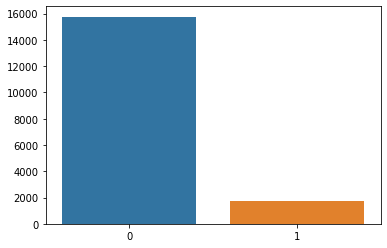

In [14]:
sns.barplot(x=target.value_counts().index,y=target.value_counts().values)

In [15]:
def missing_values_table(train,test,drop,threshold):
    mis_val = train.isnull().sum()
    mis_val_percent = 100 * train.isnull().sum() / len(train)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(train.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
    if drop: 
        to_drop = (mis_val_table_ren_columns[mis_val_table_ren_columns["% of Total Values"]>=threshold].index)
        print(to_drop)
        train.drop(to_drop,axis=1,inplace=True)
        test.drop(to_drop,axis=1,inplace=True)
    return mis_val_table_ren_columns,train,test

In [16]:
missing_values,train,test = missing_values_table(train,test,True,missing_threshold)
missing_values.head(20)

Your selected dataframe has 2396 columns.
There are 759 columns that have missing values.
Index(['Col266', 'Col288', 'Col724', 'Col463', 'Col485', 'Col813', 'Col171'], dtype='object')


,Missing Values,% of Total Values
Col266,17514,100.0
Col288,17514,100.0
Col724,17514,100.0
Col463,17514,100.0
Col485,17514,100.0
Col813,17514,100.0
Col171,17411,99.4
Col930,17127,97.8
Col40,17046,97.3
Col38,17035,97.2


In [17]:
def handle_dashes(train,test):
    for col in train.columns:
        if train[col].dtype == object:
            train[col] = pd.to_numeric(train[col],errors='coerce')
    for col in test.columns:
        if test[col].dtype == object:
            test[col] = pd.to_numeric(test[col],errors='coerce')
    return train,test 

In [18]:
train,test = handle_dashes(train,test)

In [19]:
def matchTypes(train, test):
    for col in train.columns:
        if train[col].dtype == float:
            test[col] = test[col].astype('float')
        if train[col].dtype == int:
            try:
                test[col] = test[col].astype('int')
            except:
                train[col] = train[col].astype('float')
    return train,test

In [20]:
train, test = matchTypes(train, test)

In [21]:
int_cols = train.columns[train.dtypes=='int']
float_cols = train.columns[train.dtypes=='float']

In [22]:
# np.array_equal(A,B)  # test if same shape, same elements values
# np.array_equiv(A,B)  # test if broadcastable shape, same elements values
# np.allclose(A,B,...) 
def processDuplicateColumns(train,test,columns,threshold):
    data_dict = {}
    for toProcessCols in columns:
        processedColumns = set()
        for mainCol in tqdm(toProcessCols):
            if mainCol not in processedColumns:
                arr = []
                for col in toProcessCols:
                    if col != mainCol and col not in processedColumns and np.allclose(train[mainCol],train[col],equal_nan=True) and np.allclose(test[mainCol],test[col],equal_nan=True):
                        arr.append(col)
                        processedColumns.add(col)
                if len(arr) > 0:
                    data_dict[mainCol] = arr
            processedColumns.add(mainCol)
    with open(f'{data_path}duplicate_columns.txt','w') as f:
        f.write(str(data_dict))
        f.close()
    return data_dict

In [23]:
if os.path.exists(f'{data_path}duplicate_columns.txt'):
    with open(f'{data_path}duplicate_columns.txt','r') as f:
        data = literal_eval(f.read())
else:
    data = processDuplicateColumns(train,test,[int_cols,float_cols],0)

In [24]:
for v in tqdm(data.values()):
    train.drop(v,axis=1,inplace=True)
    test.drop(v,axis=1,inplace=True)

100%|██████████| 100/100 [00:27<00:00,  3.73it/s]


In [25]:
categorical_columns = train.columns[((train.dtypes == 'int')&(train.nunique() < categorical_limit))]
for col in tqdm(categorical_columns):
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

100%|██████████| 1413/1413 [02:10<00:00, 10.80it/s] 


In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17521 entries, 0 to 17520
Columns: 2273 entries, Col3 to Col1_3
dtypes: category(1413), float64(814), int64(46)
memory usage: 138.9 MB


In [27]:
col_to_log = train.columns[((train.dtypes != 'category') & (train.max() >= log_limit))]
def getSign(val):
    if val < 0.0:
        return -1
    else:
        return 1
for col in col_to_log:
    if train[col].isna().sum() == 0 and test[col].isna().sum() == 0:
        sign = train[col].apply(getSign)
        train[col] = np.log1p(np.abs(train[col]))*sign
        sign = test[col].apply(getSign)
        test[col] = np.log1p(np.abs(test[col]))*sign

In [28]:
train.isna().sum().sum()

4324351

In [29]:
test.isna().sum().sum()

5209082

In [30]:
# correlations = train.corr(target).sort_values()
# print('Most Positive Correlations:\n', correlations.tail(15))
# print('\nMost Negative Correlations:\n', correlations.head(15))

In [31]:
cp = train.copy()
cp2 = test.copy()

In [376]:
# model1 = PCA(600)
# model2 = PCA(400)
# model3 = PCA(400)

In [470]:
model1 = TruncatedSVD(400)
# model2 = TruncatedSVD(400)
# model3 = TruncatedSVD(600)

In [471]:
train = cp.copy()
test = cp2.copy()
for col in train.columns[train.dtypes != 'category']:
    train[col].fillna(nan_value,inplace=True)
    test[col].fillna(nan_value,inplace=True)

In [472]:
train1 = train[cp.columns[cp.dtypes == 'category']]
test1 = test[cp.columns[cp.dtypes == 'category']]
train1 = pd.DataFrame(model1.fit_transform(train1))
test1 = pd.DataFrame(model1.transform(test1))
train2 = train[cp.columns[cp.dtypes == 'int']]
test2 = test[cp.columns[cp.dtypes == 'int']]
# train2 = pd.DataFrame(model2.fit_transform(train2))
# test2 = pd.DataFrame(model2.transform(test2))
train3 = train[cp.columns[cp.dtypes == 'float']]
test3 = test[cp.columns[cp.dtypes == 'float']]
# train3 = pd.DataFrame(model3.fit_transform(train3))
# test3 = pd.DataFrame(model3.transform(test3))

In [473]:
train = pd.concat([train1,train2,train3],axis=1)
test = pd.concat([test1,test2,test3],axis=1)

In [474]:
train.columns = range(train.shape[1])
test.columns = range(train.shape[1])

In [475]:
# train = cp.copy()
# test = cp2.copy()

In [476]:
# from sklearn.neural_network import MLPClassifier

In [477]:
# train.isna().sum().sum()

In [478]:
# for col in train.columns[train.dtypes != 'category']:
#     train[col].fillna(nan_value,inplace=True)
#     test[col].fillna(nan_value,inplace=True)

In [479]:
# model = MLPClassifier((200,))

In [480]:
# model.fit(train,target)

In [481]:
# pred = model.predict(test)

In [482]:
# lgbm_imp = np.loadtxt(f'{data_path}lgbm_imp_final.txt',dtype='str')
# lgbm_imp_int = np.loadtxt(f'{data_path}lgbm_imp_int2.txt',dtype='str')

In [483]:
# train = cp[np.concatenate((lgbm_imp,lgbm_imp_int))]
# test = cp2[np.concatenate((lgbm_imp,lgbm_imp_int))]

In [484]:
# train = cp[lgbm_imp]
# test = cp2[lgbm_imp]

In [485]:
# train = cp.copy()
# test = cp2.copy()

In [486]:
# train[train.columns[train.dtypes != 'category']].fillna(nan_value,inplace=True)
# train[test.columns[train.dtypes != 'category']].fillna(nan_value,inplace=True)

In [487]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17521 entries, 0 to 17520
Columns: 1260 entries, 0 to 1259
dtypes: float64(1217), int64(43)
memory usage: 168.4 MB


In [488]:
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
from sklearn.en

In [520]:
model_lgb = lgb.LGBMClassifier(class_weight='balanced',num_leaves=35)
model_xgb = xgb.XGBClassifier(learning_rate=0.15,n_estimators=100)
# model_rf = RandomForestClassifier(random_state=9)
# model_cat = cat.CatBoostClassifier()

In [521]:
kfold = StratifiedKFold(3,random_state=42)

In [522]:
for train_idx,test_idx in kfold.split(train,target):
    x_train,y_train = train.iloc[train_idx],target.iloc[train_idx]
    x_test,y_test = train.iloc[test_idx],target.iloc[test_idx]
    model_lgb.fit(x_train,y_train,eval_metric=accuracy_score)
    model_xgb.fit(x_train,y_train,eval_metric=accuracy_score)
#     model_rf.fit(x_train,y_train)
#     model_lgb.fit(x_train,y_train)
    pred = np.argmax(model_lgb.predict_proba(x_test) +model_xgb.predict_proba(x_test),axis=1)
    print(accuracy_score(y_test,pred))

0.9005307310392057
0.8914383561643836
0.8945205479452055


In [524]:
sub = pd.read_csv(f'{data_path}Sample_submission.csv')
# pred = np.argmax(model_lgb.predict_proba(test)+model_xgb.predict_proba(test)+model_rf.predict_proba(test),axis=1)
pred = np.argmax(model_lgb.predict_proba(test)+model_xgb.predict_proba(test),axis=1) 
sub.Col2 = pred
sub.to_csv('output.csv',index=False)
len(pred[pred==0])

19859

In [122]:
# train.to_csv('Train2.csv',index=False)

In [ ]:
# np.savetxt(f'{data_path}lgbm_imp_final.txt',train.columns[model.feature_importances_ > 0].values,fmt='%s')

In [ ]:
# train.columns[model.feature_importances_ > 20].values

In [ ]:
# model.feature_importances_

In [ ]:
# train.shape

In [ ]:
# len(lgbm_imp)

In [ ]:
# train.columns[model.feature_importances_ == 0]

In [ ]:
# l5 = train.columns[model.feature_importances_ < 5]
# g5 = train.columns[model.feature_importances_ >= 5]
# l10 = train.columns[(model.feature_importances_ < 10)&(model.feature_importances_ > 10)]
# g10 = train.columns[(model.feature_importances_ < 10)&(model.feature_importances_ > 10)]

In [ ]:
# test.Col1_2.nunique()

In [ ]:
len(train.columns[model_lgb.feature_importances_ == 0].values)

In [ ]:
model_lgb.feature_importances_

In [ ]:
cp.shape

In [ ]:
cp.info()

In [394]:
# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Activation, ThresholdedReLU, MaxPooling2D, Embedding, Dropout
# from keras.optimizers import Adam, SGD, RMSprop
# from keras import backend as K
# from keras.callbacks import EarlyStopping
# from keras.layers.advanced_activations import PReLU
# from keras.layers.normalization import BatchNormalization
# from keras import optimizers
# from sklearn.preprocessing import MinMaxScaler

# X = train.values.reshape(train.shape[0],train.shape[1],1)
# test_df = test.values.reshape(test.shape[0],test.shape[1],1)
# print("X Shape: ", X.shape)
# print("Test DF: ", test_df.shape)


# inputshape = (X.shape[1], X.shape[2])
# print("Input Shape: ", inputshape)

# LSTM_PARAM = {"batch_size":512,
#               "verbose":2,
#               "epochs":20}

# # Model Architecture
# model_lstm = Sequential([
#     LSTM(100, input_shape=inputshape),
#     Activation('relu'),
#     Dropout(0.5),
#     Dense(100),
#     Activation('relu'),
#     Dropout(0.5),
#     Dense(10),
#     Activation('relu'),
#     Dropout(0.5),
#     Dense(1, activation = 'sigmoid')
# ])


# # Compile
# opt = optimizers.Adam(0.001)
# model_lstm.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
# hist = model_lstm.fit(X, target,
#                       **LSTM_PARAM)

# pred = model_lstm.predict_classes(test_df)

# sub.Col2 = pred
# sub.to_csv('output.csv',index=False)
# len(pred[pred==0])

Using TensorFlow backend.
